# CAP 6615 Neural Networks Programming Assignment 3 – Recurrent Neural Network

### Keyuan Lu, Wenxuan Bao, Yiming Xu, Yufan Chen, Yue Bai

In [2]:
import numpy as np
import random 
from datetime import datetime
from numpy import genfromtxt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Step 1 - Design and build a dataset for RNN model

### Select S&P500 Dataset and Schiller P/E ratio. Make an overlay of the Schiller P/E from 1 Jan 1960 to 31 Dec 2020, onto the S&P500 for the same period.

In [3]:
# Read s&p500 price data and schiller pe data.
# Note that 'HistoricalPrices.csv' only includes data after 1978
# Therefore, we use two datasets for s&p500 price ('HistoricalPrices.csv' and 'HistoricalPrices_old.csv' ), 
# and will combine them later
price_new=pd.read_csv('HistoricalPrices.csv')
price_old=pd.read_csv('HistoricalPrices_old.csv')
pe=pd.read_csv('ie_data_PE_full.csv')

In [4]:
# Note that the P/E ratio is monthly data 
pe=pe.rename({'Date':'Date_PE'},axis=1)
pe

,Date_PE,PE_CAPE
0,1960.01,18.338285
1,1960.02,17.545275
2,1960.03,17.286021
3,1960.04,17.429767
4,1960.05,17.256171
...,...,...
727,2020.08,31.152309
728,2020.09,30.833593
729,2020.10,31.277783
730,2020.11,32.471647


In [5]:
# remove redundant variables
price_old = price_old.drop(['Volume', 'Adj Close' ], 1)
# transform Date to date timestamp
price_old['Date'] = pd.to_datetime(price_old['Date'])
price_old = price_old.loc[ (price_old['Date'] < '1978-01-03') &  (price_old['Date']  >= '1960-01-01' )]
price_old

,Date,Open,High,Low,Close
2511,1960-01-04,59.910000,59.910000,59.910000,59.910000
2512,1960-01-05,60.389999,60.389999,60.389999,60.389999
2513,1960-01-06,60.130001,60.130001,60.130001,60.130001
2514,1960-01-07,59.689999,59.689999,59.689999,59.689999
2515,1960-01-08,59.500000,59.500000,59.500000,59.500000
...,...,...,...,...,...
7016,1977-12-23,93.800003,94.989998,93.750000,94.690002
7017,1977-12-27,94.690002,95.209999,94.089996,94.690002
7018,1977-12-28,94.690002,95.199997,93.989998,94.750000
7019,1977-12-29,94.750000,95.430000,94.099998,94.940002


In [6]:
price_new['Date'] = pd.to_datetime(price_new['Date'])
#reverse the dataset
price_new = price_new.iloc[::-1].reset_index(drop = True)
#reset the column names
price_new. columns = ['Date', 'Open', 'High', 'Low', 'Close']
price_new

,Date,Open,High,Low,Close
0,1978-01-03,93.82,95.15,93.49,93.82
1,1978-01-04,93.52,94.10,93.16,93.52
2,1978-01-05,92.74,94.53,92.51,92.74
3,1978-01-06,91.62,92.66,91.05,91.62
4,1978-01-09,90.64,91.52,90.01,90.64
...,...,...,...,...,...
10839,2020-12-24,3694.03,3703.82,3689.32,3703.06
10840,2020-12-28,3723.03,3740.51,3723.03,3735.36
10841,2020-12-29,3750.01,3756.12,3723.31,3727.04
10842,2020-12-30,3736.19,3744.63,3730.21,3732.04


In [7]:
# combine two s&p500 datasets
# now the dataset includes all the s&p 500 price data from 1 Jan 1960 to 31 Dec 2020  
frames = [price_old, price_new]
price = pd.concat(frames).reset_index(drop = True)
price

,Date,Open,High,Low,Close
0,1960-01-04,59.910000,59.910000,59.910000,59.910000
1,1960-01-05,60.389999,60.389999,60.389999,60.389999
2,1960-01-06,60.130001,60.130001,60.130001,60.130001
3,1960-01-07,59.689999,59.689999,59.689999,59.689999
4,1960-01-08,59.500000,59.500000,59.500000,59.500000
...,...,...,...,...,...
15349,2020-12-24,3694.030000,3703.820000,3689.320000,3703.060000
15350,2020-12-28,3723.030000,3740.510000,3723.030000,3735.360000
15351,2020-12-29,3750.010000,3756.120000,3723.310000,3727.040000
15352,2020-12-30,3736.190000,3744.630000,3730.210000,3732.040000


In [8]:
price['Date_PE']=0.0
for i in range(price.shape[0]):
    month = price['Date'][i].month
    year = price['Date'][i].year
    price.loc[i, 'Date_PE']=year+month*0.01
# merge sp500 data with the Schiller P/E ratio based on Date.
data_full = pd.merge(price, pe, how='left', on='Date_PE')
data_full = data_full.drop(['Date_PE' ], 1)

In [9]:
# save the merged dataset
data_full.to_csv('Price_PE.csv')

In [10]:
data_full

,Date,Open,High,Low,Close,PE_CAPE
0,1960-01-04,59.910000,59.910000,59.910000,59.910000,18.338285
1,1960-01-05,60.389999,60.389999,60.389999,60.389999,18.338285
2,1960-01-06,60.130001,60.130001,60.130001,60.130001,18.338285
3,1960-01-07,59.689999,59.689999,59.689999,59.689999,18.338285
4,1960-01-08,59.500000,59.500000,59.500000,59.500000,18.338285
...,...,...,...,...,...,...
15349,2020-12-24,3694.030000,3703.820000,3689.320000,3703.060000,33.769789
15350,2020-12-28,3723.030000,3740.510000,3723.030000,3735.360000,33.769789
15351,2020-12-29,3750.010000,3756.120000,3723.310000,3727.040000,33.769789
15352,2020-12-30,3736.190000,3744.630000,3730.210000,3732.040000,33.769789


### Make an overlay of the Schiller P/E onto the S&P500 for the same period.

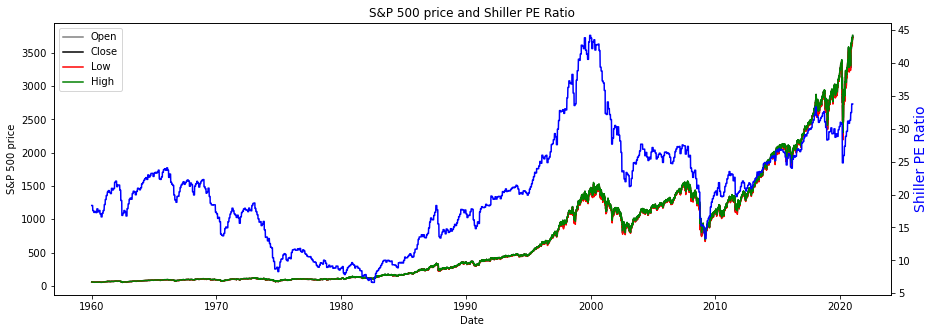

In [11]:
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, data_full.Open.values, color='grey', label='Open')
plt.plot(data_full.Date, data_full.Close.values, color='black', label='Close')
plt.plot(data_full.Date, data_full.Low.values, color='red', label='Low')
plt.plot(data_full.Date, data_full.High.values, color='green', label='High')
plt.title('S&P 500 price and Shiller PE Ratio')
plt.xlabel('Date')
plt.ylabel('S&P 500 price')
plt.legend(loc='best')
# twin object for two different y-axis on the sample plot
ax2=plt.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data_full.Date, data_full.PE_CAPE.values,color="blue")
ax2.set_ylabel("Shiller PE Ratio", color="blue",fontsize=14)
plt.show()

#### Here, we are only using ClOSE price and Cyclicily adjusted PE-ratio to train the model

In [12]:
dataset = data_full[ ['Close', 'PE_CAPE']].values
dataset

array([[  59.91      ,   18.33828499],
       [  60.389999  ,   18.33828499],
       [  60.130001  ,   18.33828499],
       ...,
       [3727.04      ,   33.76978942],
       [3732.04      ,   33.76978942],
       [3756.07      ,   33.76978942]])

## From Schiller P/E report analysis, we use PE ratio to "hint" about the RNN according to its price state and add this as a new data column
### refer https://www.longtermtrends.net/sp500-price-earnings-shiller-pe-ratio/

In [13]:
# '5' indicates stocks are extremely undervalued
# '4' indicates stocks are undervalued
# '3' indicates stocks are fair
# '2' indicates stocks are overvalued
# '1' indicates stocks are in a bubble
# '0' indicates stocks are in an extreme bubble
def checkPEState(pe_ratio):
    state = 0
    if pe_ratio < 7.5:
        state = 5
    elif pe_ratio >= 7.5 and pe_ratio < 12.75:
        state = 4
    elif pe_ratio >= 12.75 and pe_ratio < 15:
        state = 3
    elif pe_ratio >= 15 and pe_ratio < 20:
        state = 2
    elif pe_ratio >= 20 and pe_ratio < 25:
        state = 1
    elif pe_ratio >= 25:
        state = 0
    return state

In [14]:
# Adding the PEState as additional feature
dataset = np.append(dataset,np.zeros([len(dataset),1]),1)
for x in dataset:
    s = checkPEState(x[1])
    x[2] = s
dataset

array([[5.99100000e+01, 1.83382850e+01, 2.00000000e+00],
       [6.03899990e+01, 1.83382850e+01, 2.00000000e+00],
       [6.01300010e+01, 1.83382850e+01, 2.00000000e+00],
       ...,
       [3.72704000e+03, 3.37697894e+01, 0.00000000e+00],
       [3.73204000e+03, 3.37697894e+01, 0.00000000e+00],
       [3.75607000e+03, 3.37697894e+01, 0.00000000e+00]])

In [15]:
# extract the timestamp data
date_data= data_full[ ['Date']].values

In [16]:
# Feature Scaling: min-max normalization of features
sc = MinMaxScaler(feature_range = (0, 1))
dataset_scaled = sc.fit_transform(dataset)
dataset_scaled

array([[0.00208161, 0.31149771, 0.4       ],
       [0.0022112 , 0.31149771, 0.4       ],
       [0.002141  , 0.31149771, 0.4       ],
       ...,
       [0.99216225, 0.72235494, 0.        ],
       [0.99351219, 0.72235494, 0.        ],
       [1.        , 0.72235494, 0.        ]])

In [17]:
# number of timepoint and number of feature
n_rows, n_cols = dataset_scaled.shape
(n_rows, n_cols)

(15354, 3)

In [18]:
# general settings
# The number of expected features in the input x is 3
input_size = 3
# output_size = 4 as we want to predict the next one, two, three, and four trading data 
output_size = 4
# sequence length is 180
window_size = 180

In [19]:
# Creating a data structure with 180 timesteps and 4 output
X_full = []
y_full = []
date_full = []
for i in range( n_rows - window_size - output_size +1):
    X_full.append(dataset_scaled[i:i+window_size, ])
    y_full.append(dataset_scaled[i+window_size: i+ window_size + output_size, 0])
    date_full.append(date_data[i+window_size])
    
X_full, y_full, date_full = np.array(X_full), np.array(y_full), np.array(date_full)
y_full = np.reshape(y_full, (y_full.shape[0], 1, y_full.shape[1]))

In [20]:
X_full.shape

(15171, 180, 3)

In [21]:
y_full.shape

(15171, 1, 4)

### The NYSE and NASDAQ average about 253 trading days a year. We use 20\% for testing, i.e. first 200 days for training, and consecutive 53 datapoints for testing.

### We further split the training dataset to smaller training dataset (80\%) and validation set (20\%).

In [22]:
X_train = []; y_train = []; date_train = []
X_val = []; y_val = []; date_val = []
X_test = []; y_test = []; date_test = []
for i in range(X_full.shape[0]):
    if(i  %  253 >= 200):
        X_test.append(X_full[i])
        y_test.append(y_full[i])
        date_test.append(date_full[i])
    elif (i % 253 < 160):
        X_train.append(X_full[i])
        y_train.append(y_full[i])
        date_train.append(date_full[i])
    else:
        X_val.append(X_full[i])
        y_val.append(y_full[i])
        date_val.append(date_full[i])
X_train, y_train, date_train = np.array(X_train), np.array(y_train), np.array(date_train) 
X_val, y_val, date_val = np.array(X_val), np.array(y_val), np.array(date_val) 
X_test, y_test, date_test = np.array(X_test), np.array(y_test), np.array(date_test)                

In [23]:
#Input shape --> (Sample size, Sequence Length, Input Size)
X_train.shape

(9600, 180, 3)

In [24]:
X_val.shape

(2400, 180, 3)

In [25]:
X_test.shape

(3171, 180, 3)

In [25]:
y_train.shape

(9600, 1, 4)

## Step 2 - Design and develop RNN in Python, using libraries such as PyTorch (and, if necessary, Tensor Flow). 

In [26]:
# addtional setting for the RNN
hidden_size = 16
num_layers = 3
num_epochs = 100
learning_rate = 0.005

In [27]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out)
        #just want last time step output 
        return out[:, -1, :], hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [28]:
rnn = Model(input_size, output_size, hidden_size, num_layers)
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [29]:
# display the rnn structure
rnn

Model(
  (rnn): RNN(3, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
)

In [30]:
# display the weights (including bias) name and shape
for name, param in rnn.named_parameters():
    print(name)
    print(param.data.shape)

rnn.weight_ih_l0
torch.Size([16, 3])
rnn.weight_hh_l0
torch.Size([16, 16])
rnn.bias_ih_l0
torch.Size([16])
rnn.bias_hh_l0
torch.Size([16])
rnn.weight_ih_l1
torch.Size([16, 16])
rnn.weight_hh_l1
torch.Size([16, 16])
rnn.bias_ih_l1
torch.Size([16])
rnn.bias_hh_l1
torch.Size([16])
fc.weight
torch.Size([4, 16])
fc.bias
torch.Size([4])


## Step 3 - Train your RNN on your Training Set (S&P500 data, from Step 1, above) then test to ensure it functions correctly when predicting the next one, two, three, and four trading data (close price) before you go on to Step 4.  

In [31]:
#set seed for reproducible results 
torch.manual_seed(1)
np.random.seed(1)
loss_all_1 = []
loss_all_1_val = []
for epoch in range(num_epochs):
    # make training sets in torch
    inputs = Variable(torch.from_numpy(X_train).float())
    labels = Variable(torch.from_numpy(y_train).float())
    
    # zero the parameter (weight) gradients
    optimiser.zero_grad()

    # Perform forward pass
    output, hidden = rnn(inputs)   
    
    # Compute loss
    loss = criterion(output.reshape(-1), labels.view(-1))
    loss_all_1 += [loss]
       
    # Backward pass
    loss.backward(retain_graph=True)
       
    #loss for validation
    inputs_val = Variable(torch.from_numpy(X_val).float())
    labels_val = Variable(torch.from_numpy(y_val).float())
    output_val, hidden_val = rnn(inputs_val)     
    loss_val = criterion(output_val.reshape(-1), labels_val.view(-1))
    loss_all_1_val += [loss_val]
    
    if (epoch % 10 == 0 ):
        print("Epoch ", epoch, "MSE: ", loss.item())
    
    # Update parameters
    optimiser.step()                                


Epoch  0 MSE:  0.10017715394496918
Epoch  10 MSE:  0.01911911740899086
Epoch  20 MSE:  0.006228677928447723
Epoch  30 MSE:  0.00188858387991786
Epoch  40 MSE:  0.0010334947146475315
Epoch  50 MSE:  0.0003368451725691557
Epoch  60 MSE:  0.00019818218424916267
Epoch  70 MSE:  0.00014125069719739258
Epoch  80 MSE:  0.00010515744361327961
Epoch  90 MSE:  9.114987915381789e-05


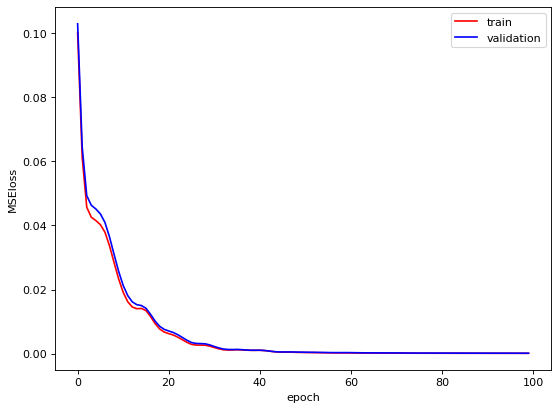

In [32]:
plt.figure(figsize=[8,6],dpi=80)
plt.plot(np.array(loss_all_1), 'r', label = 'train')
plt.plot(np.array(loss_all_1_val), 'b', label = 'validation')
plt.xlabel("epoch")
plt.ylabel("MSEloss")
plt.legend()
# plt.savefig('MSEloss_Model1.eps')

### From the plot of MSE loss, we could see that the MSE of training set and validation set are quite similar. Therefore, no overfitting issue.

In [33]:
out_temp = np.concatenate((output.detach().numpy()[:, [0]], output.detach().numpy()[:, [0]],output.detach().numpy()[:, [0]]), axis=1)
out_temp.shape
predicted_price = sc.inverse_transform(out_temp)[:, [0]]
predicted_price

array([[  72.333145],
       [  72.05818 ],
       [  71.675674],
       ...,
       [3146.7832  ],
       [3152.8555  ],
       [3160.8362  ]], dtype=float32)

In [34]:
predicted_price.shape

(9600, 1)

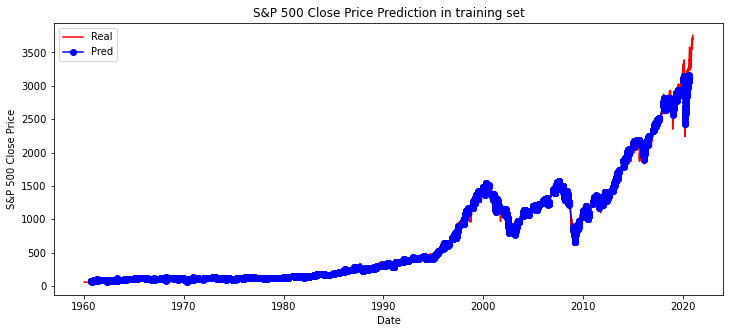

In [35]:
# Visualising the results in training dataset
plt.figure(1, figsize=(12, 5))
plt.plot(data_full.Date, dataset[:,0], color = 'red', label = 'Real')
plt.plot(date_train, predicted_price, color = 'blue', label = 'Pred', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

### Accuracy will be computed in terms of error defined as prediction_error := |predicted_price - actual_price| / actual_price 

In [36]:
# compute prediction_error := (predicted_price - actual_price) / actual_price 
def prediction_error(target, pred):
    error = abs(pred - target)/target
    return error

In [37]:
out_temp = np.concatenate( (y_train[:, :, 0], y_train[:, :, 0], y_train[:, :, 0]), axis = 1)
target_train = sc.inverse_transform(out_temp)[:, [0]]
error_train = prediction_error(target_train, predicted_price)

### Graph prediction_error as a function of timestamp (e.g., DD/MM/YYYY) for all data in the Training Set. 

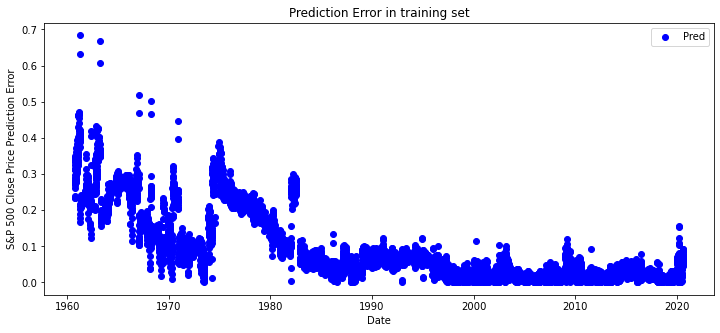

In [38]:
plt.figure(1, figsize=(12, 5))
plt.plot(date_train, error_train, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in training set')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()

## Step 4 - Test your RNN accuracy in predicting the next one, two, three, and four datapoints in the dataset from 1 Jan 1980 through the present day, using a sliding sampling window of width 180 days. 

In [44]:
# predict next one day
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [0]], 
                           output_test.detach().numpy()[:, [0]], 
                           output_test.detach().numpy()[:, [0]]), axis=1)
predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
predicted_price_test

array([[  76.03377],
       [  76.53701],
       [  77.16832],
       ...,
       [3267.3423 ],
       [3265.6343 ],
       [3264.8813 ]], dtype=float32)

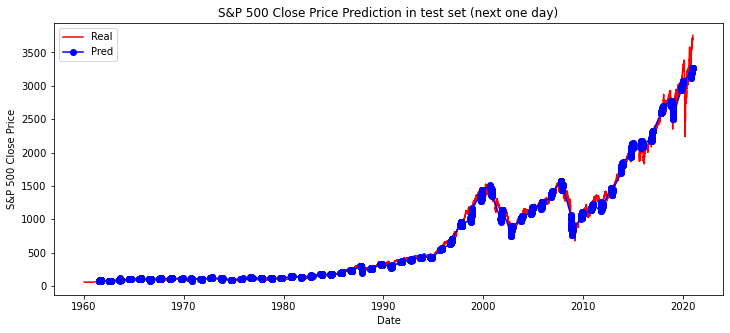

In [80]:
# Visualising the results in test dataset
plt.figure(1, figsize=(12, 5))
plt.plot(data_full.Date, dataset[:,0], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

In [81]:
out_temp = np.concatenate( (y_test[:, :, 0], y_test[:, :, 0], y_test[:, :, 0]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(target_test, predicted_price_test)

### Graph prediction_error as a function of timestamp (e.g., DD/MM/YYYY) for all data in the Test Set. 

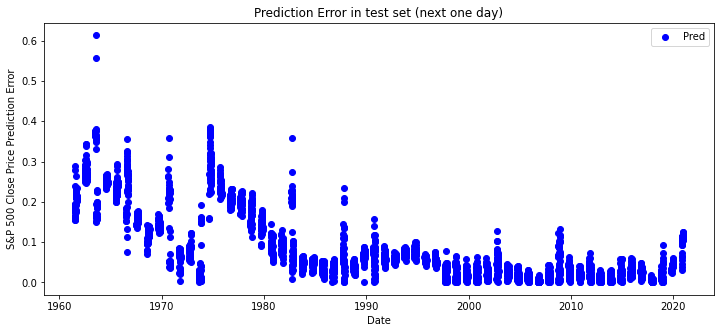

In [82]:
plt.figure(1, figsize=(12, 5))
plt.plot(date_test, error_test, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()

In [83]:
# predict next two day
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [1]], 
                           output_test.detach().numpy()[:, [1]], 
                           output_test.detach().numpy()[:, [1]]), axis=1)
predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (y_test[:, :, 1], y_test[:, :, 1], y_test[:, :, 1]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(target_test, predicted_price_test)
predicted_price_test

array([[  89.70962 ],
       [  90.700424],
       [  91.00183 ],
       ...,
       [3461.6975  ],
       [3459.7183  ],
       [3459.8486  ]], dtype=float32)

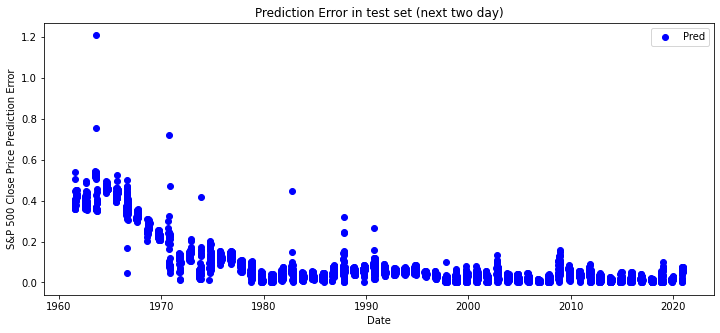

In [84]:
plt.figure(1, figsize=(12, 5))
plt.plot(date_test + pd.Timedelta('1 day'), error_test, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (next two day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()

In [85]:
# predict next three day
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [2]], 
                           output_test.detach().numpy()[:, [2]], 
                           output_test.detach().numpy()[:, [2]]), axis=1)
predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (y_test[:, :, 2], y_test[:, :, 2], y_test[:, :, 2]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(target_test, predicted_price_test)
predicted_price_test

array([[  67.920135],
       [  68.91635 ],
       [  69.33302 ],
       ...,
       [3338.7163  ],
       [3337.3855  ],
       [3339.0234  ]], dtype=float32)

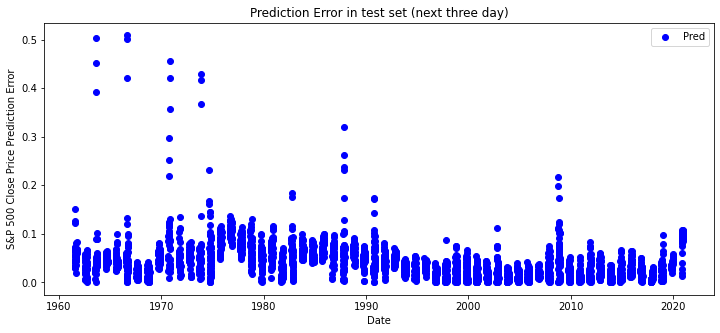

In [86]:
plt.figure(1, figsize=(12, 5))
plt.plot(date_test + pd.Timedelta('2 day'), error_test, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (next three day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()

In [87]:
# predict next four day
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [3]], 
                           output_test.detach().numpy()[:, [3]], 
                           output_test.detach().numpy()[:, [3]]), axis=1)
predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (y_test[:, :, 3], y_test[:, :, 3], y_test[:, :, 3]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(target_test, predicted_price_test)
predicted_price_test

array([[  65.61562],
       [  66.62746],
       [  66.91269],
       ...,
       [3458.5261 ],
       [3456.7944 ],
       [3457.4172 ]], dtype=float32)

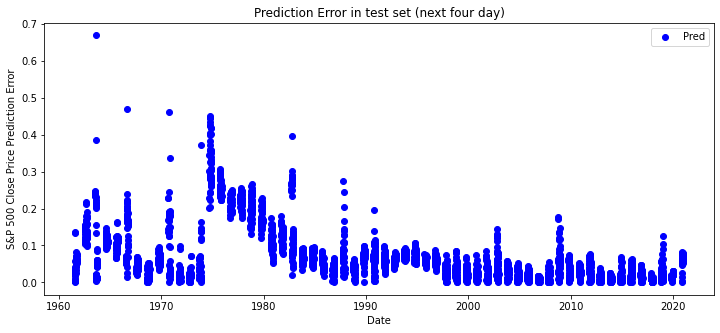

In [88]:
plt.figure(1, figsize=(12, 5))
plt.plot(date_test + pd.Timedelta('3 day'), error_test, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (next four day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()

### In case we want to only display the result after 1980

In [89]:
myDatetime = np.datetime64("1980-01-01")
date_test_partial = date_test[date_test>myDatetime]
error_partial = error_test[date_test>myDatetime]

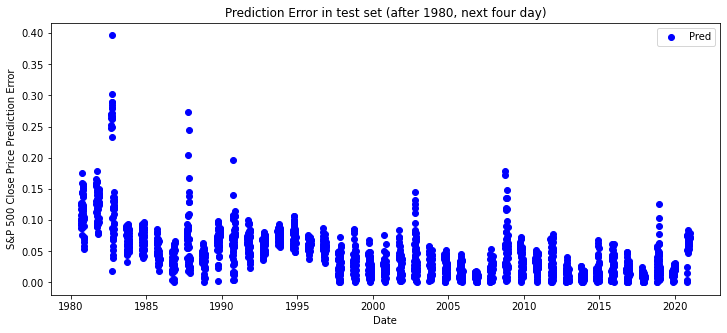

In [90]:
plt.figure(1, figsize=(12, 5))
plt.plot(date_test_partial, error_partial, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (after 1980, next four day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()

## Step 5 - Optimize your RNN performance to yield maximum achievable accuracy (e.g., minimum predicted_error) over the entire Training Set and Test Set.  Repeat Step 4 graphing operation to show this optimized result.

### reconstruct the training set and test set. (No validation set at this time)

In [53]:
# number of timepoint and number of feature
n_rows, n_cols = dataset_scaled.shape
# Creating a data structure with 180 timesteps and 4 output
X_full = []
y_full = []
date_full = []
for i in range( n_rows - window_size - output_size +1):
    X_full.append(dataset_scaled[i:i+window_size, ])
    y_full.append(dataset_scaled[i+window_size: i+window_size+output_size, 0])
    date_full.append(date_data[i+window_size])
    
X_full, y_full, date_full = np.array(X_full), np.array(y_full), np.array(date_full)
y_full = np.reshape(y_full, (y_full.shape[0], 1, y_full.shape[1]))

In [54]:
X_train = []; y_train = []; date_train = []
X_test = []; y_test = []; date_test = []
for i in range(X_full.shape[0]):
    if(i  %  253 >= 200):
        X_test.append(X_full[i])
        y_test.append(y_full[i])
        date_test.append(date_full[i])
    else:
        X_train.append(X_full[i])
        y_train.append(y_full[i])
        date_train.append(date_full[i])
X_train, y_train, date_train = np.array(X_train), np.array(y_train), np.array(date_train)          
X_test, y_test, date_test = np.array(X_test), np.array(y_test), np.array(date_test)      

### decrease the number layer from 3 to 2, increase hidden unit size from 16 to 32 

In [69]:
input_size = 3
hidden_size = 32
num_layers = 2
output_size = 4
num_epochs = 100
learning_rate = 0.005
window_size = 180

In [70]:
rnn = Model (input_size, output_size, hidden_size, num_layers)
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [ ]:
# display the rnn structure
rnn

In [ ]:
# display the weights (including bias) name and shape
for name, param in rnn.named_parameters():
    print(name)
    print(param.data.shape)

In [1]:
#set seed for reproducible results 
torch.manual_seed(1)
np.random.seed(1)
for epoch in range(num_epochs):
    # make training sets in torch
    inputs = Variable(torch.from_numpy(X_train).float())
    labels = Variable(torch.from_numpy(y_train).float())

    output, hidden = rnn(inputs) 
    
    loss = criterion(output.reshape(-1), labels.view(-1))
    
    if (epoch % 10 == 0 ):
        print("Epoch ", epoch, "MSE: ", loss.item())
    optimiser.zero_grad()

    # Backward pass
    loss.backward(retain_graph=True)

    # Update parameters
    optimiser.step()        

NameError: name 'torch' is not defined

In [75]:
#predict next one day (idx = 0)
idx = 0
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]], 
                           output_test.detach().numpy()[:, [idx]], 
                           output_test.detach().numpy()[:, [idx]]), axis=1)
predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
predicted_price_test

array([[  76.03377],
       [  76.53701],
       [  77.16832],
       ...,
       [3267.3423 ],
       [3265.6343 ],
       [3264.8813 ]], dtype=float32)

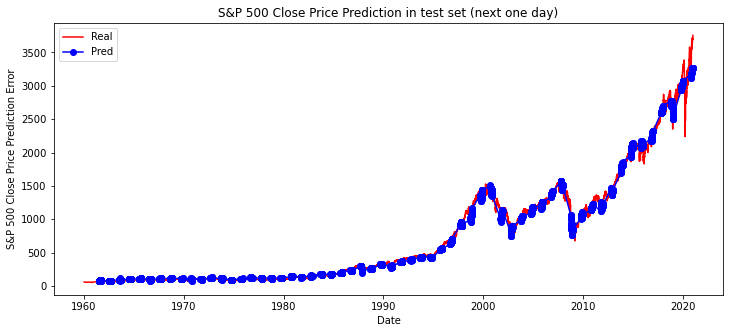

In [76]:
# Visualising the results in test dataset
plt.figure(1, figsize=(12, 5))
plt.plot(data_full.Date, dataset[:,0], color = 'red', label = 'Real')
plt.plot(date_test,
         predicted_price_test, color = 'blue', label = 'Pred', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()

In [91]:
out_temp = np.concatenate( (y_test[:, :, idx], y_test[:, :, idx], y_test[:, :, idx]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(target_test, predicted_price_test)

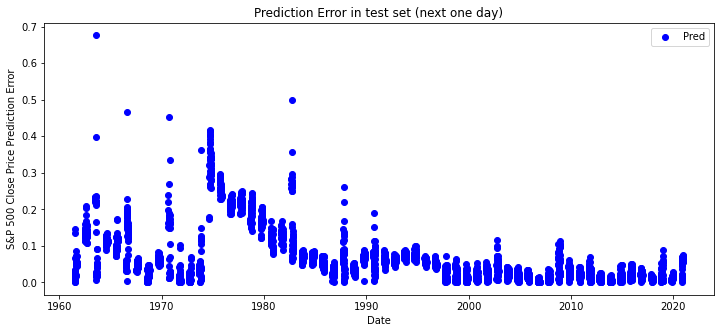

In [92]:
plt.figure(1, figsize=(12, 5))
plt.plot(date_test, error_test, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()

In [97]:
#predict next two day (idx = 1)
idx = 1
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]], 
                           output_test.detach().numpy()[:, [idx]], 
                           output_test.detach().numpy()[:, [idx]]), axis=1)
predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (y_test[:, :, idx], y_test[:, :, idx], y_test[:, :, idx]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(target_test, predicted_price_test)
predicted_price_test

array([[  89.70962 ],
       [  90.700424],
       [  91.00183 ],
       ...,
       [3461.6975  ],
       [3459.7183  ],
       [3459.8486  ]], dtype=float32)

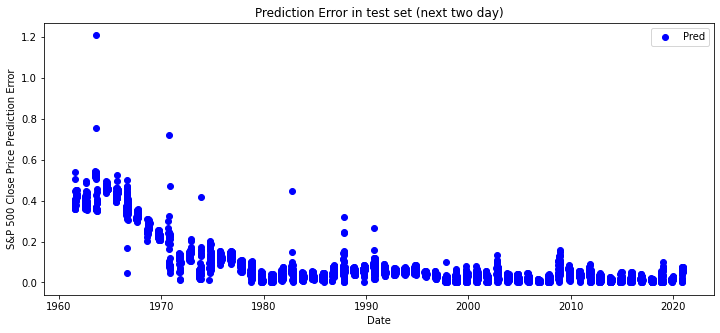

In [98]:
plt.figure(1, figsize=(12, 5))
plt.plot(date_test + pd.Timedelta('1 day'), error_test, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (next two day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()

In [99]:
#predict next three day (idx = 2)
idx = 2
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]], 
                           output_test.detach().numpy()[:, [idx]], 
                           output_test.detach().numpy()[:, [idx]]), axis=1)
predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (y_test[:, :, idx], y_test[:, :, idx], y_test[:, :, idx]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(target_test, predicted_price_test)
predicted_price_test

array([[  67.920135],
       [  68.91635 ],
       [  69.33302 ],
       ...,
       [3338.7163  ],
       [3337.3855  ],
       [3339.0234  ]], dtype=float32)

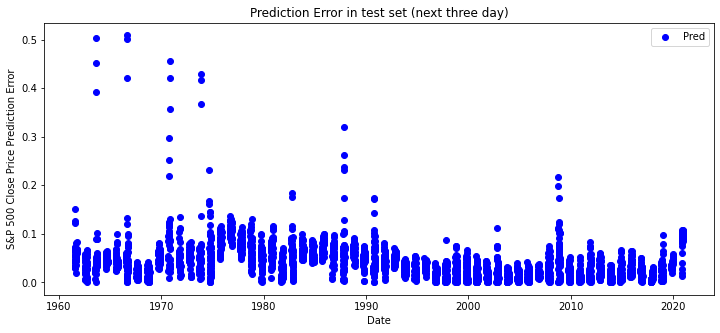

In [100]:
plt.figure(1, figsize=(12, 5))
plt.plot(date_test + pd.Timedelta('2 day'), error_test, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (next three day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()

In [101]:
#predict next four day (idx = 3)
idx = 3
test_inputs = Variable(torch.from_numpy(X_test).float())
output_test, _ = rnn(test_inputs)
out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]], 
                           output_test.detach().numpy()[:, [idx]], 
                           output_test.detach().numpy()[:, [idx]]), axis=1)
predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
out_temp = np.concatenate( (y_test[:, :, idx], y_test[:, :, idx], y_test[:, :, idx]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_test = prediction_error(target_test, predicted_price_test)
predicted_price_test

array([[  65.61562],
       [  66.62746],
       [  66.91269],
       ...,
       [3458.5261 ],
       [3456.7944 ],
       [3457.4172 ]], dtype=float32)

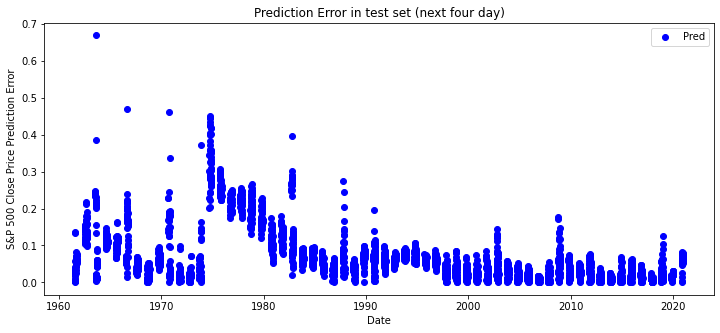

In [102]:
plt.figure(1, figsize=(12, 5))
plt.plot(date_test + pd.Timedelta('3 day'), error_test, color = 'blue', label = 'Pred', marker= 'o', linestyle='None')
plt.title('Prediction Error in test set (next four day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()

## Step 6 -  Corrupt your Test Set (from 1), above) by adding noise

In [103]:
# standard deviation
sd = [0.0, 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
def NoiseData(dataset, sigma):
    dataset_noise = np.ndarray(shape=dataset.shape, dtype=np.float32)
    #set seed for random numbers
    random.seed(1)
    for i in range(len(dataset)):
        s = np.random.normal(0, sigma, 18)
        index = random.sample(list(range(window_size)), 18)
        dataset_noise[i] = dataset[i]    
        dataset_noise[i, index, 0] = dataset_noise[i, index, 0] + s
    return dataset_noise   

In [113]:
#predict next day (idx = 0)
idx = 0
out_temp = np.concatenate( (y_test[:, :, idx], y_test[:, :, idx], y_test[:, :, idx]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in sd:
    print(sigma)
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]], 
                               output_test.detach().numpy()[:, [idx]],  
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(target_test, predicted_price_test)
    error_res_all.append(error.reshape(-1))

0.0
0.001
0.002
0.003
0.005
0.01
0.02
0.03
0.05
0.1


In [114]:
labels = date_test[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=sd).T
error_df

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1961-07-07,0.156056,0.156058,0.156045,0.155990,0.155987,0.155906,0.156315,0.156053,0.156547,0.157006
1961-07-10,0.164770,0.155732,0.162367,0.193638,0.220049,0.270450,0.197176,0.101281,0.468031,0.567565
1961-07-11,0.174735,0.175268,0.171834,0.179561,0.179701,0.174564,0.175303,0.175859,0.189931,0.171092
1961-07-12,0.185681,0.185643,0.185752,0.186080,0.184847,0.184723,0.184659,0.179758,0.195267,0.212159
1961-07-13,0.194899,0.194792,0.179461,0.184993,0.219130,0.241746,0.333952,0.309582,0.515261,0.064991
...,...,...,...,...,...,...,...,...,...,...
2020-12-21,0.116016,0.116041,0.116041,0.116015,0.115987,0.115628,0.115790,0.115610,0.116333,0.121176
2020-12-22,0.113650,0.113760,0.114184,0.113497,0.114143,0.114356,0.114443,0.112078,0.103886,0.099898
2020-12-23,0.114544,0.114542,0.114260,0.114710,0.114857,0.114120,0.114472,0.115615,0.109882,0.109564
2020-12-24,0.118125,0.118123,0.118173,0.118167,0.118162,0.118142,0.118250,0.117718,0.117827,0.118071


In [ ]:
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
plt.figure(1, figsize=(12, 5))
for i in range(len(sd)):    
    plt.plot(date_test, error_res_all[i], color=cmaps[i], lw=1, label = sd[i])  
plt.xlabel('Date')
plt.ylabel('Prediction error')
plt.title('Prediction error with Different Noise Levels (next one day)')
plt.legend(loc="lower right") 

In [ ]:
for i in range(len(sd)): 
    plt.figure(1, figsize=(12, 5))
    plt.plot(date_test, error_res_all[i], color=cmaps[i], lw=1, label = sd[i])  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next one day)')
    plt.legend(loc="lower right")  
    plt.show()

In [115]:
#predict next two day (idx = 1)
idx = 1
out_temp = np.concatenate( (y_test[:, :, idx], y_test[:, :, idx], y_test[:, :, idx]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in sd:
    print(sigma)
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]], 
                               output_test.detach().numpy()[:, [idx]],  
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(target_test, predicted_price_test)
    error_res_all.append(error.reshape(-1))

0.0
0.001
0.002
0.003
0.005
0.01
0.02
0.03
0.05
0.1


In [116]:
temp = date_test + pd.Timedelta('1 day')
labels = temp[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=sd).T
error_df

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1961-07-08,0.365235,0.365224,0.365228,0.365218,0.365275,0.365215,0.365279,0.365454,0.365233,0.364890
1961-07-11,0.380734,0.389686,0.401635,0.344195,0.341575,0.286192,0.302167,0.326334,0.693538,2.814630
1961-07-12,0.393169,0.393166,0.393173,0.393176,0.393125,0.393127,0.393151,0.393218,0.393589,0.393770
1961-07-13,0.405439,0.405477,0.405289,0.405432,0.405628,0.405108,0.402168,0.405748,0.408721,0.422311
1961-07-14,0.394507,0.395275,0.358717,0.279860,0.353722,0.219701,0.426081,0.904646,0.894238,0.210847
...,...,...,...,...,...,...,...,...,...,...
2020-12-22,0.060900,0.060915,0.060931,0.060917,0.060672,0.060668,0.061070,0.060564,0.061230,0.057411
2020-12-23,0.061417,0.061380,0.061045,0.060005,0.060424,0.062350,0.059682,0.063970,0.062320,0.055583
2020-12-24,0.065179,0.065110,0.065278,0.065291,0.065167,0.066292,0.064350,0.065668,0.074254,0.057496
2020-12-25,0.073793,0.073783,0.073786,0.073720,0.073667,0.073640,0.073887,0.073670,0.075082,0.074018


In [ ]:
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
plt.figure(1, figsize=(12, 5))
for i in range(len(sd)):    
    plt.plot(date_test+ pd.Timedelta('1 day'), error_res_all[i], color=cmaps[i], lw=1, label = sd[i])  
plt.xlabel('Date')
plt.ylabel('Prediction error')
plt.title('Prediction error with Different Noise Levels (next two day)')
plt.legend(loc="lower right") 

In [ ]:
for i in range(len(sd)): 
    plt.figure(1, figsize=(12, 5))
    plt.plot(date_test+ pd.Timedelta('1 day'), error_res_all[i], color=cmaps[i], lw=1, label = sd[i])  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next two day)')
    plt.legend(loc="lower right")  
    plt.show()

In [117]:
#predict next three day (idx = 2)
idx = 2
out_temp = np.concatenate( (y_test[:, :, idx], y_test[:, :, idx], y_test[:, :, idx]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in sd:
    print(sigma)
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]], 
                               output_test.detach().numpy()[:, [idx]],  
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(target_test, predicted_price_test)
    error_res_all.append(error.reshape(-1))

0.0
0.001
0.002
0.003
0.005
0.01
0.02
0.03
0.05
0.1


In [118]:
temp = date_test + pd.Timedelta('2 day')
labels = temp[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=sd).T
error_df

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1961-07-09,0.033949,0.033942,0.033940,0.033957,0.033920,0.033977,0.034153,0.033875,0.033928,0.033997
1961-07-12,0.055057,0.058949,0.025003,0.004376,0.020980,0.015001,0.193811,0.335527,0.112254,2.863767
1961-07-13,0.068964,0.069730,0.067529,0.068559,0.068834,0.064758,0.061279,0.095163,0.087660,0.011244
1961-07-14,0.065992,0.065895,0.066057,0.066088,0.066011,0.066205,0.064393,0.063822,0.065176,0.067753
1961-07-15,0.071445,0.059350,0.123036,0.016926,0.105341,0.283971,0.189301,0.116642,0.822211,0.738238
...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0.094016,0.093974,0.094018,0.094063,0.094141,0.094097,0.094708,0.092842,0.094340,0.095331
2020-12-24,0.097579,0.097694,0.097588,0.097715,0.097552,0.097754,0.098602,0.097535,0.101200,0.090914
2020-12-25,0.106186,0.106295,0.106170,0.106378,0.106072,0.105849,0.106659,0.107804,0.107817,0.112123
2020-12-26,0.104548,0.104527,0.104572,0.104528,0.104604,0.104468,0.104910,0.104752,0.103360,0.104722


In [ ]:
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
plt.figure(1, figsize=(12, 5))
for i in range(len(sd)):    
    plt.plot(date_test+ pd.Timedelta('2 day'), error_res_all[i], color=cmaps[i], lw=1, label = sd[i])  
plt.xlabel('Date')
plt.ylabel('Prediction error')
plt.title('Prediction error with Different Noise Levels (next three day)')
plt.legend(loc="lower right")  

In [ ]:
for i in range(len(sd)): 
    plt.figure(1, figsize=(12, 5))
    plt.plot(date_test+ pd.Timedelta('2 day'), error_res_all[i], color=cmaps[i], lw=1, label = sd[i])  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next three day)')
    plt.legend(loc="lower right")  
    plt.show()

In [119]:
#predict next four day (idx = 3)
idx = 3
out_temp = np.concatenate( (y_test[:, :, idx], y_test[:, :, idx], y_test[:, :, idx]), axis = 1)
target_test = sc.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in sd:
    print(sigma)
    dataset_test_noise = NoiseData(X_test, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn(test_inputs)
    out_temp = np.concatenate((output_test.detach().numpy()[:, [idx]], 
                               output_test.detach().numpy()[:, [idx]],  
                               output_test.detach().numpy()[:, [idx]]), axis=1)
    predicted_price_test = sc.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(target_test, predicted_price_test)
    error_res_all.append(error.reshape(-1))

0.0
0.001
0.002
0.003
0.005
0.01
0.02
0.03
0.05
0.1


In [120]:
temp = date_test + pd.Timedelta('3 day')
labels = temp[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=sd).T
error_df

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1961-07-10,0.004526,0.004532,0.004505,0.004504,0.004496,0.004571,0.003947,0.004378,0.003535,0.004512
1961-07-13,0.027250,0.036138,0.022446,0.130869,0.024110,0.152892,0.116531,0.004275,0.690641,1.848376
1961-07-14,0.025011,0.024737,0.025023,0.022795,0.024910,0.020406,0.021487,0.015174,0.026516,0.009801
1961-07-15,0.037742,0.037687,0.037865,0.037705,0.037588,0.037582,0.037669,0.037201,0.036172,0.040727
1961-07-16,0.041384,0.041059,0.060305,0.007374,0.038850,0.024913,0.123241,0.390320,0.107471,2.328157
...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.065600,0.065580,0.065504,0.065455,0.065378,0.065524,0.066562,0.065533,0.064073,0.059817
2020-12-25,0.073690,0.073827,0.073693,0.073375,0.073385,0.075682,0.077176,0.073499,0.071701,0.080077
2020-12-26,0.072045,0.072102,0.071768,0.072047,0.072153,0.070996,0.071442,0.072073,0.075546,0.077928
2020-12-27,0.073752,0.073760,0.073756,0.073666,0.073648,0.073511,0.073351,0.074820,0.072978,0.074546


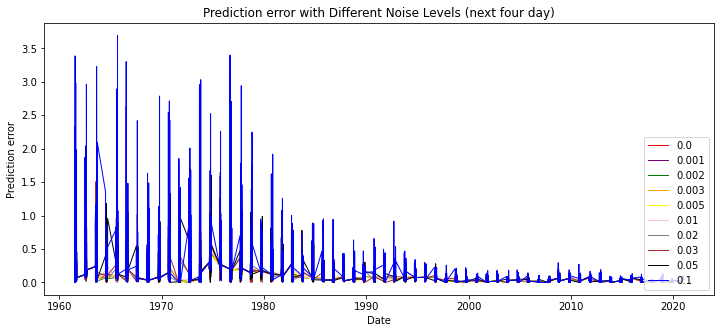

In [122]:
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
plt.figure(1, figsize=(12, 5))
for i in range(len(sd)):    
    plt.plot(date_test+ pd.Timedelta('3 day'), error_res_all[i], color=cmaps[i], lw=1, label = sd[i])  
plt.xlabel('Date')
plt.ylabel('Prediction error')
plt.title('Prediction error with Different Noise Levels (next four day)')
plt.legend(loc="lower right")  

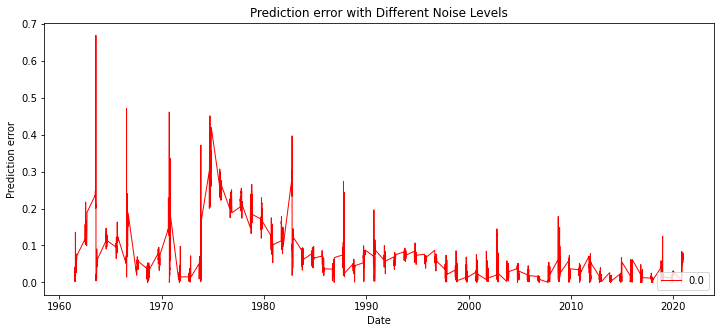

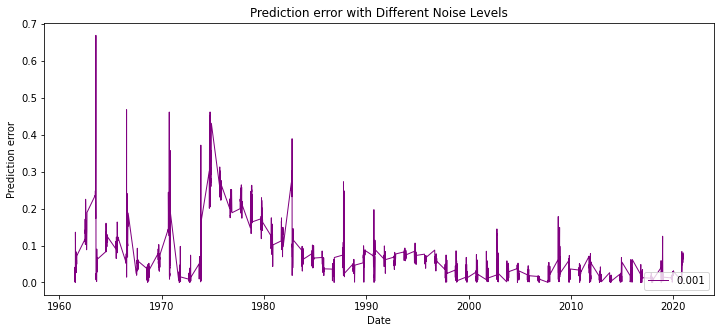

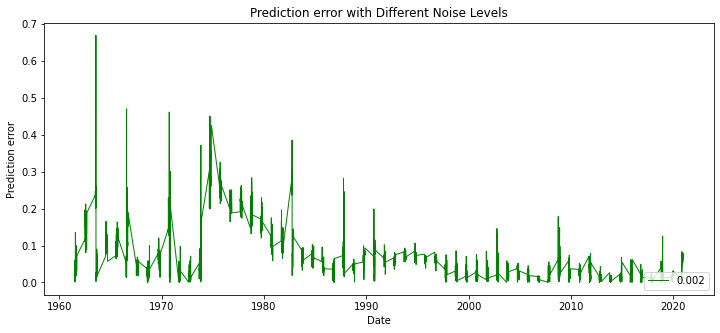

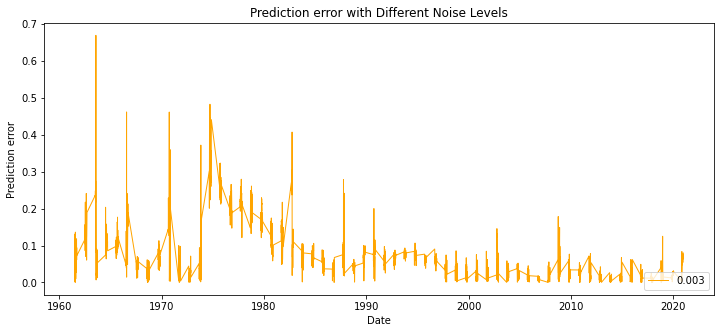

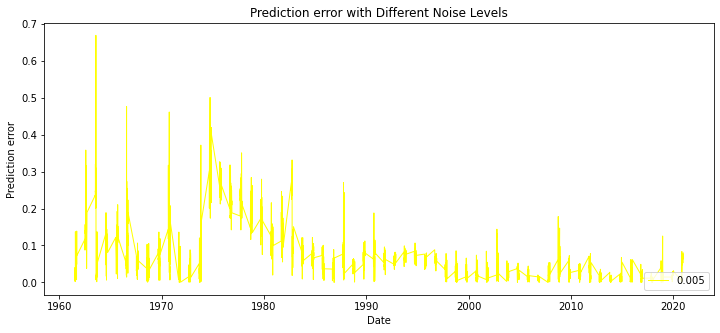

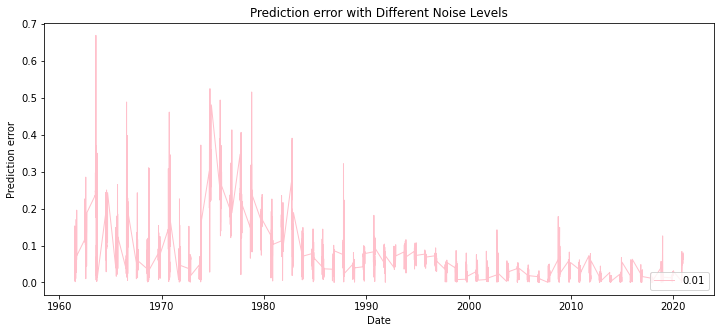

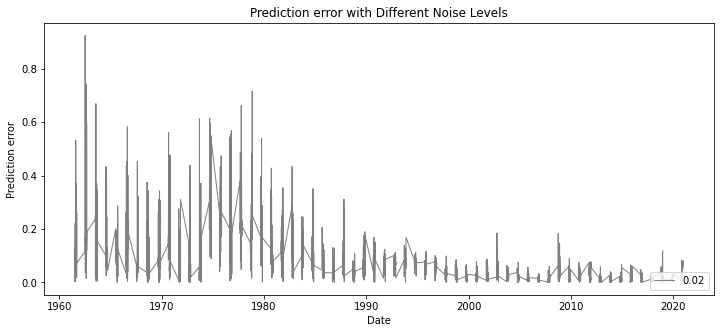

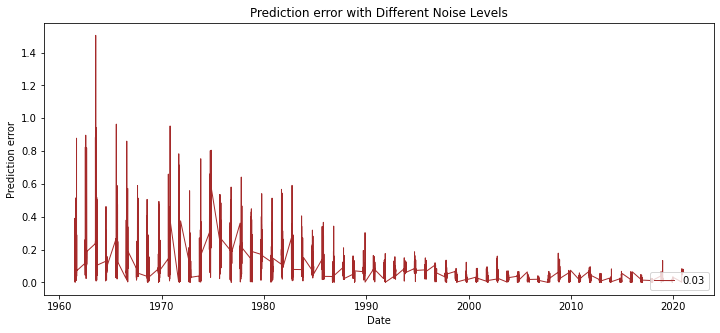

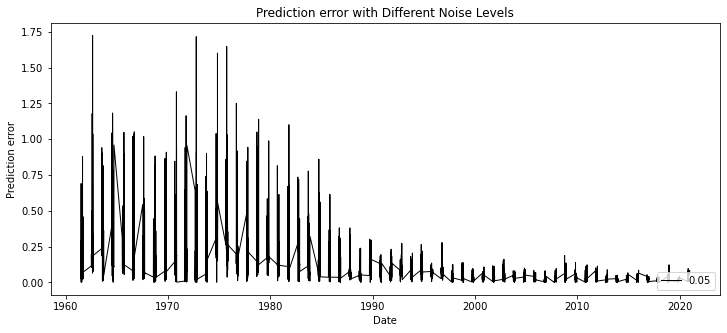

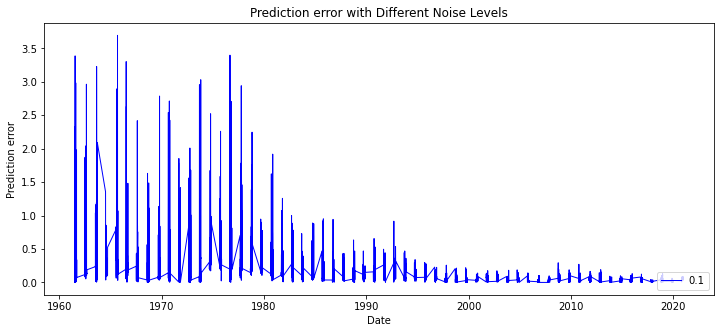

In [124]:
for i in range(len(sd)): 
    plt.figure(1, figsize=(12, 5))
    plt.plot(date_test+ pd.Timedelta('3 day'), error_res_all[i], color=cmaps[i], lw=1, label = sd[i])  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next four day)')
    plt.legend(loc="lower right")  
    plt.show()

In [71]:
#reference:https://github.com/thundercomb/pytorch-stock-predictor-rnn/blob/master/pytorch-stock-predictor-lstm.ipynb